Fitxer llegit: C:\Users\bfeli\rates_all_metrics_cleaned.csv n = 1196
Processant dependent: feminicidis


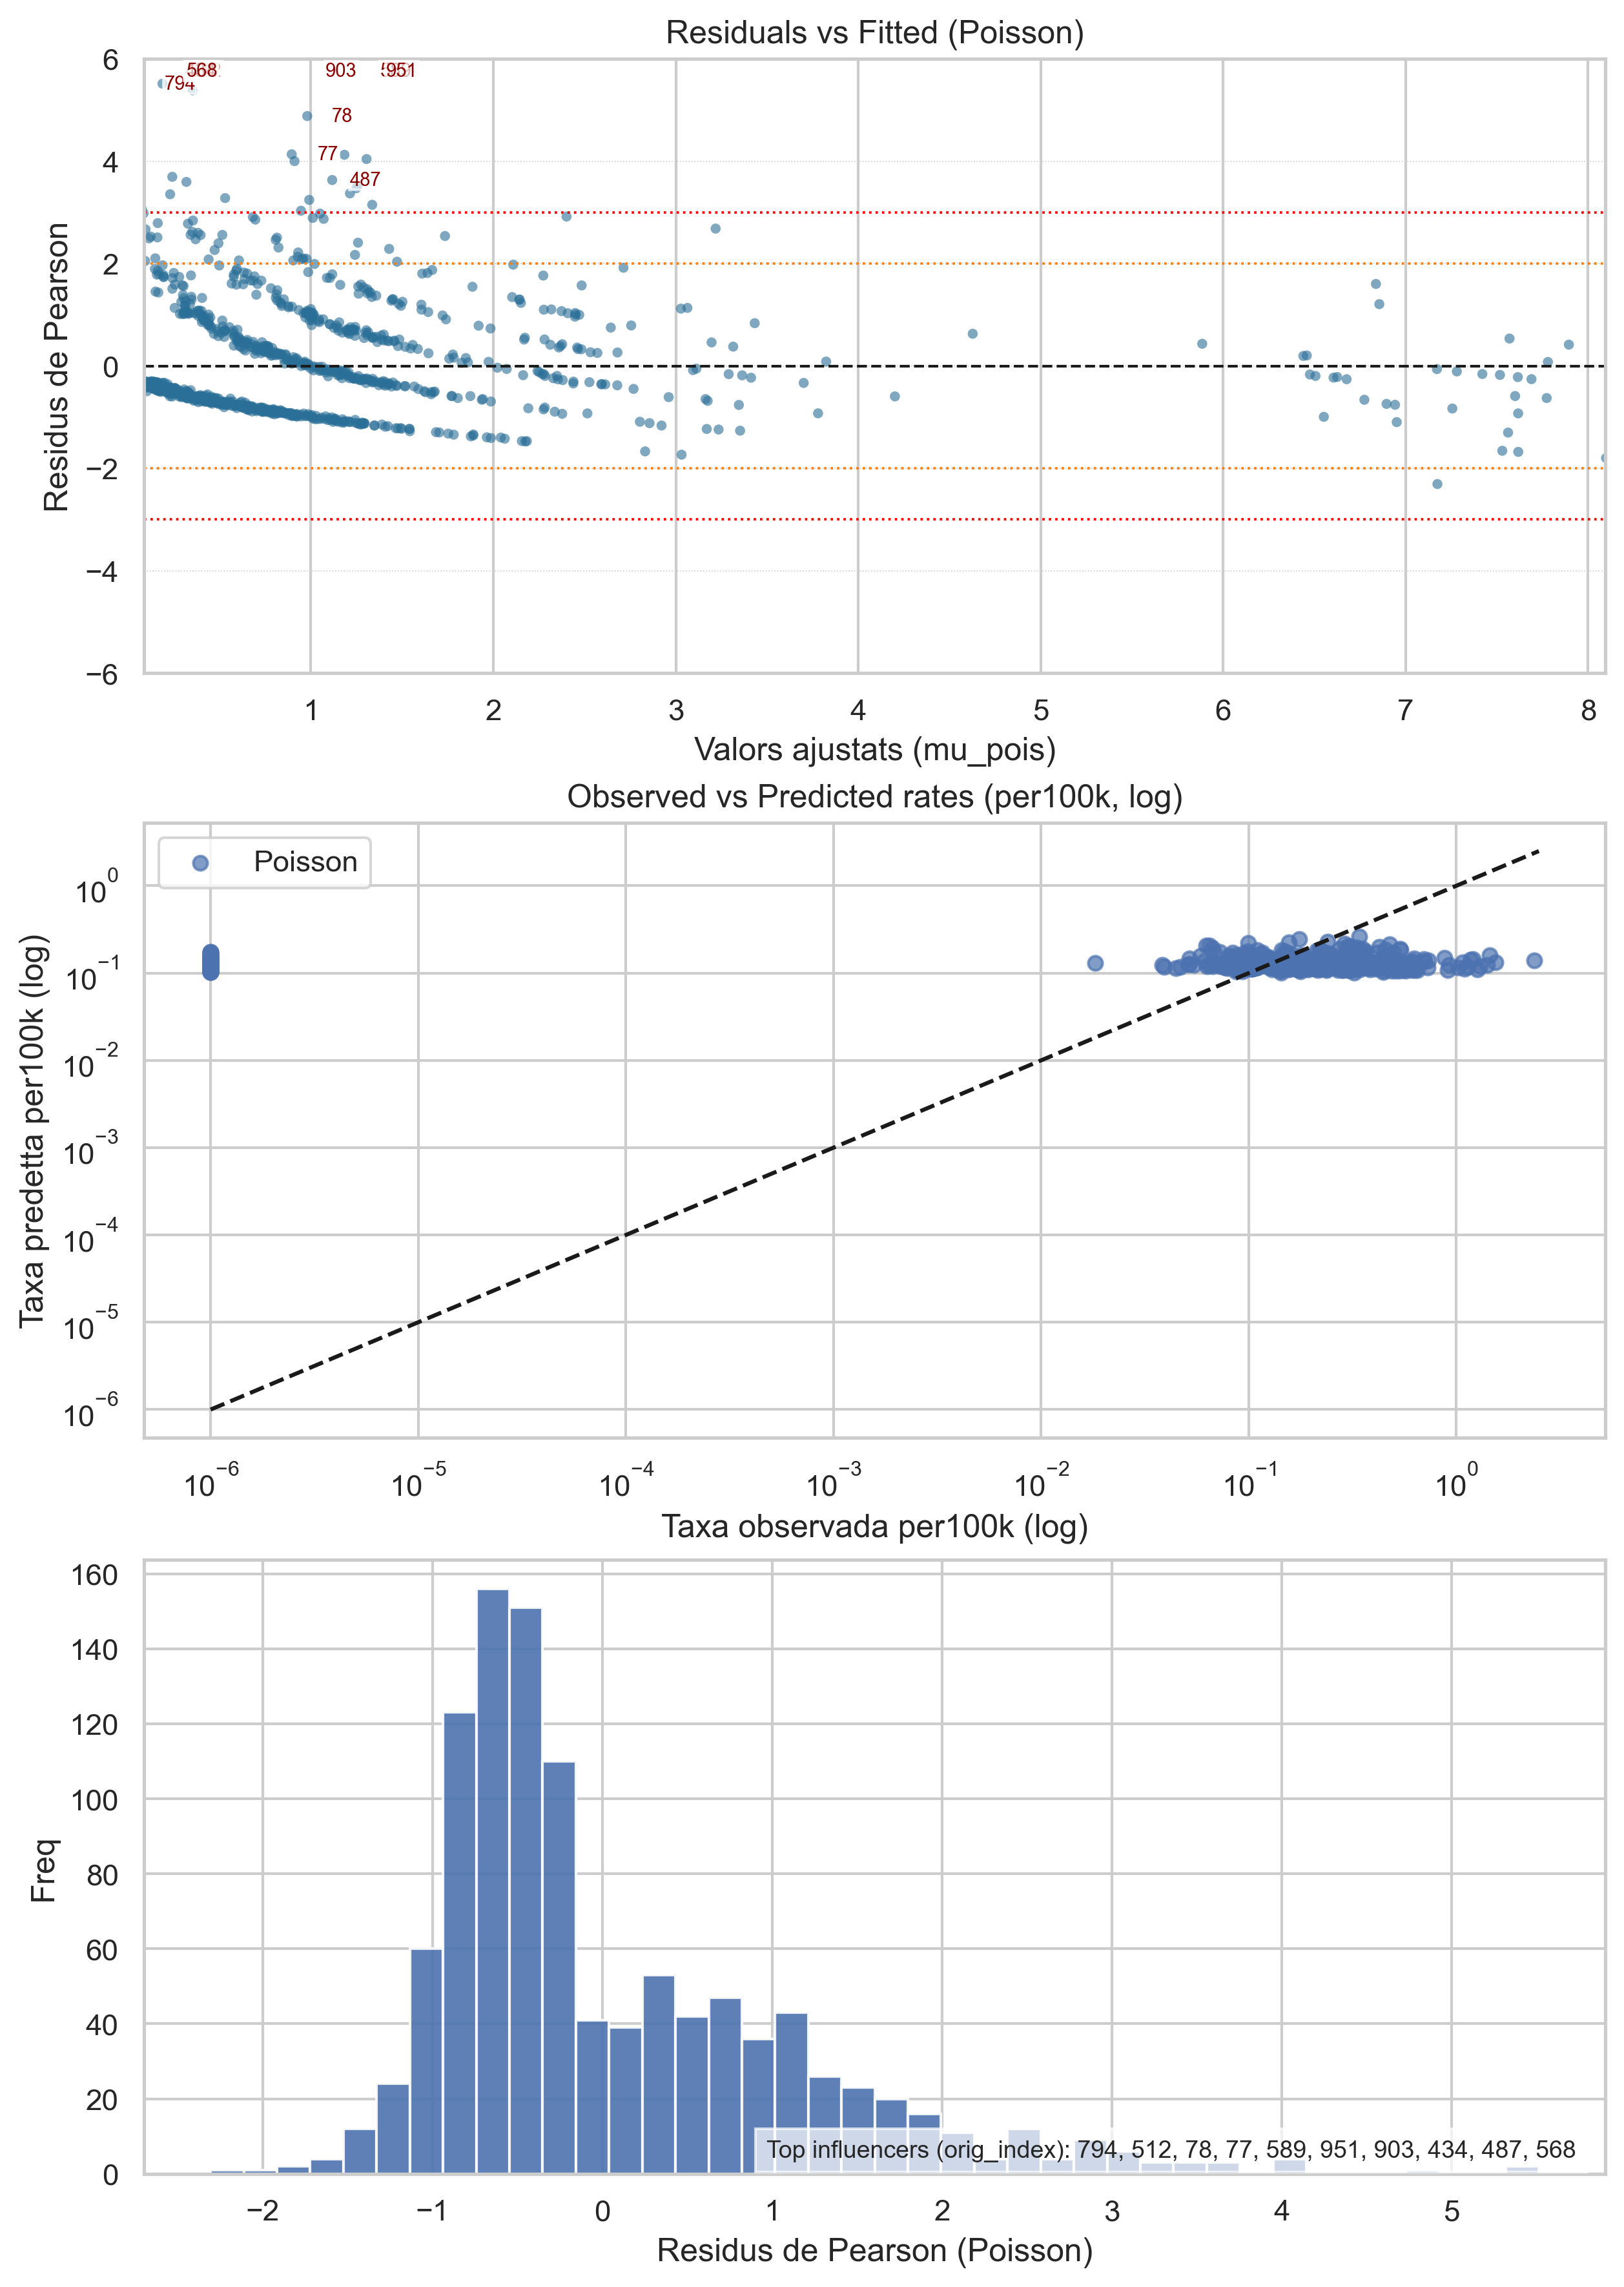

  feminicidis: n=1092 disp=1.141 AIC=2603.46
Processant dependent: denuncies


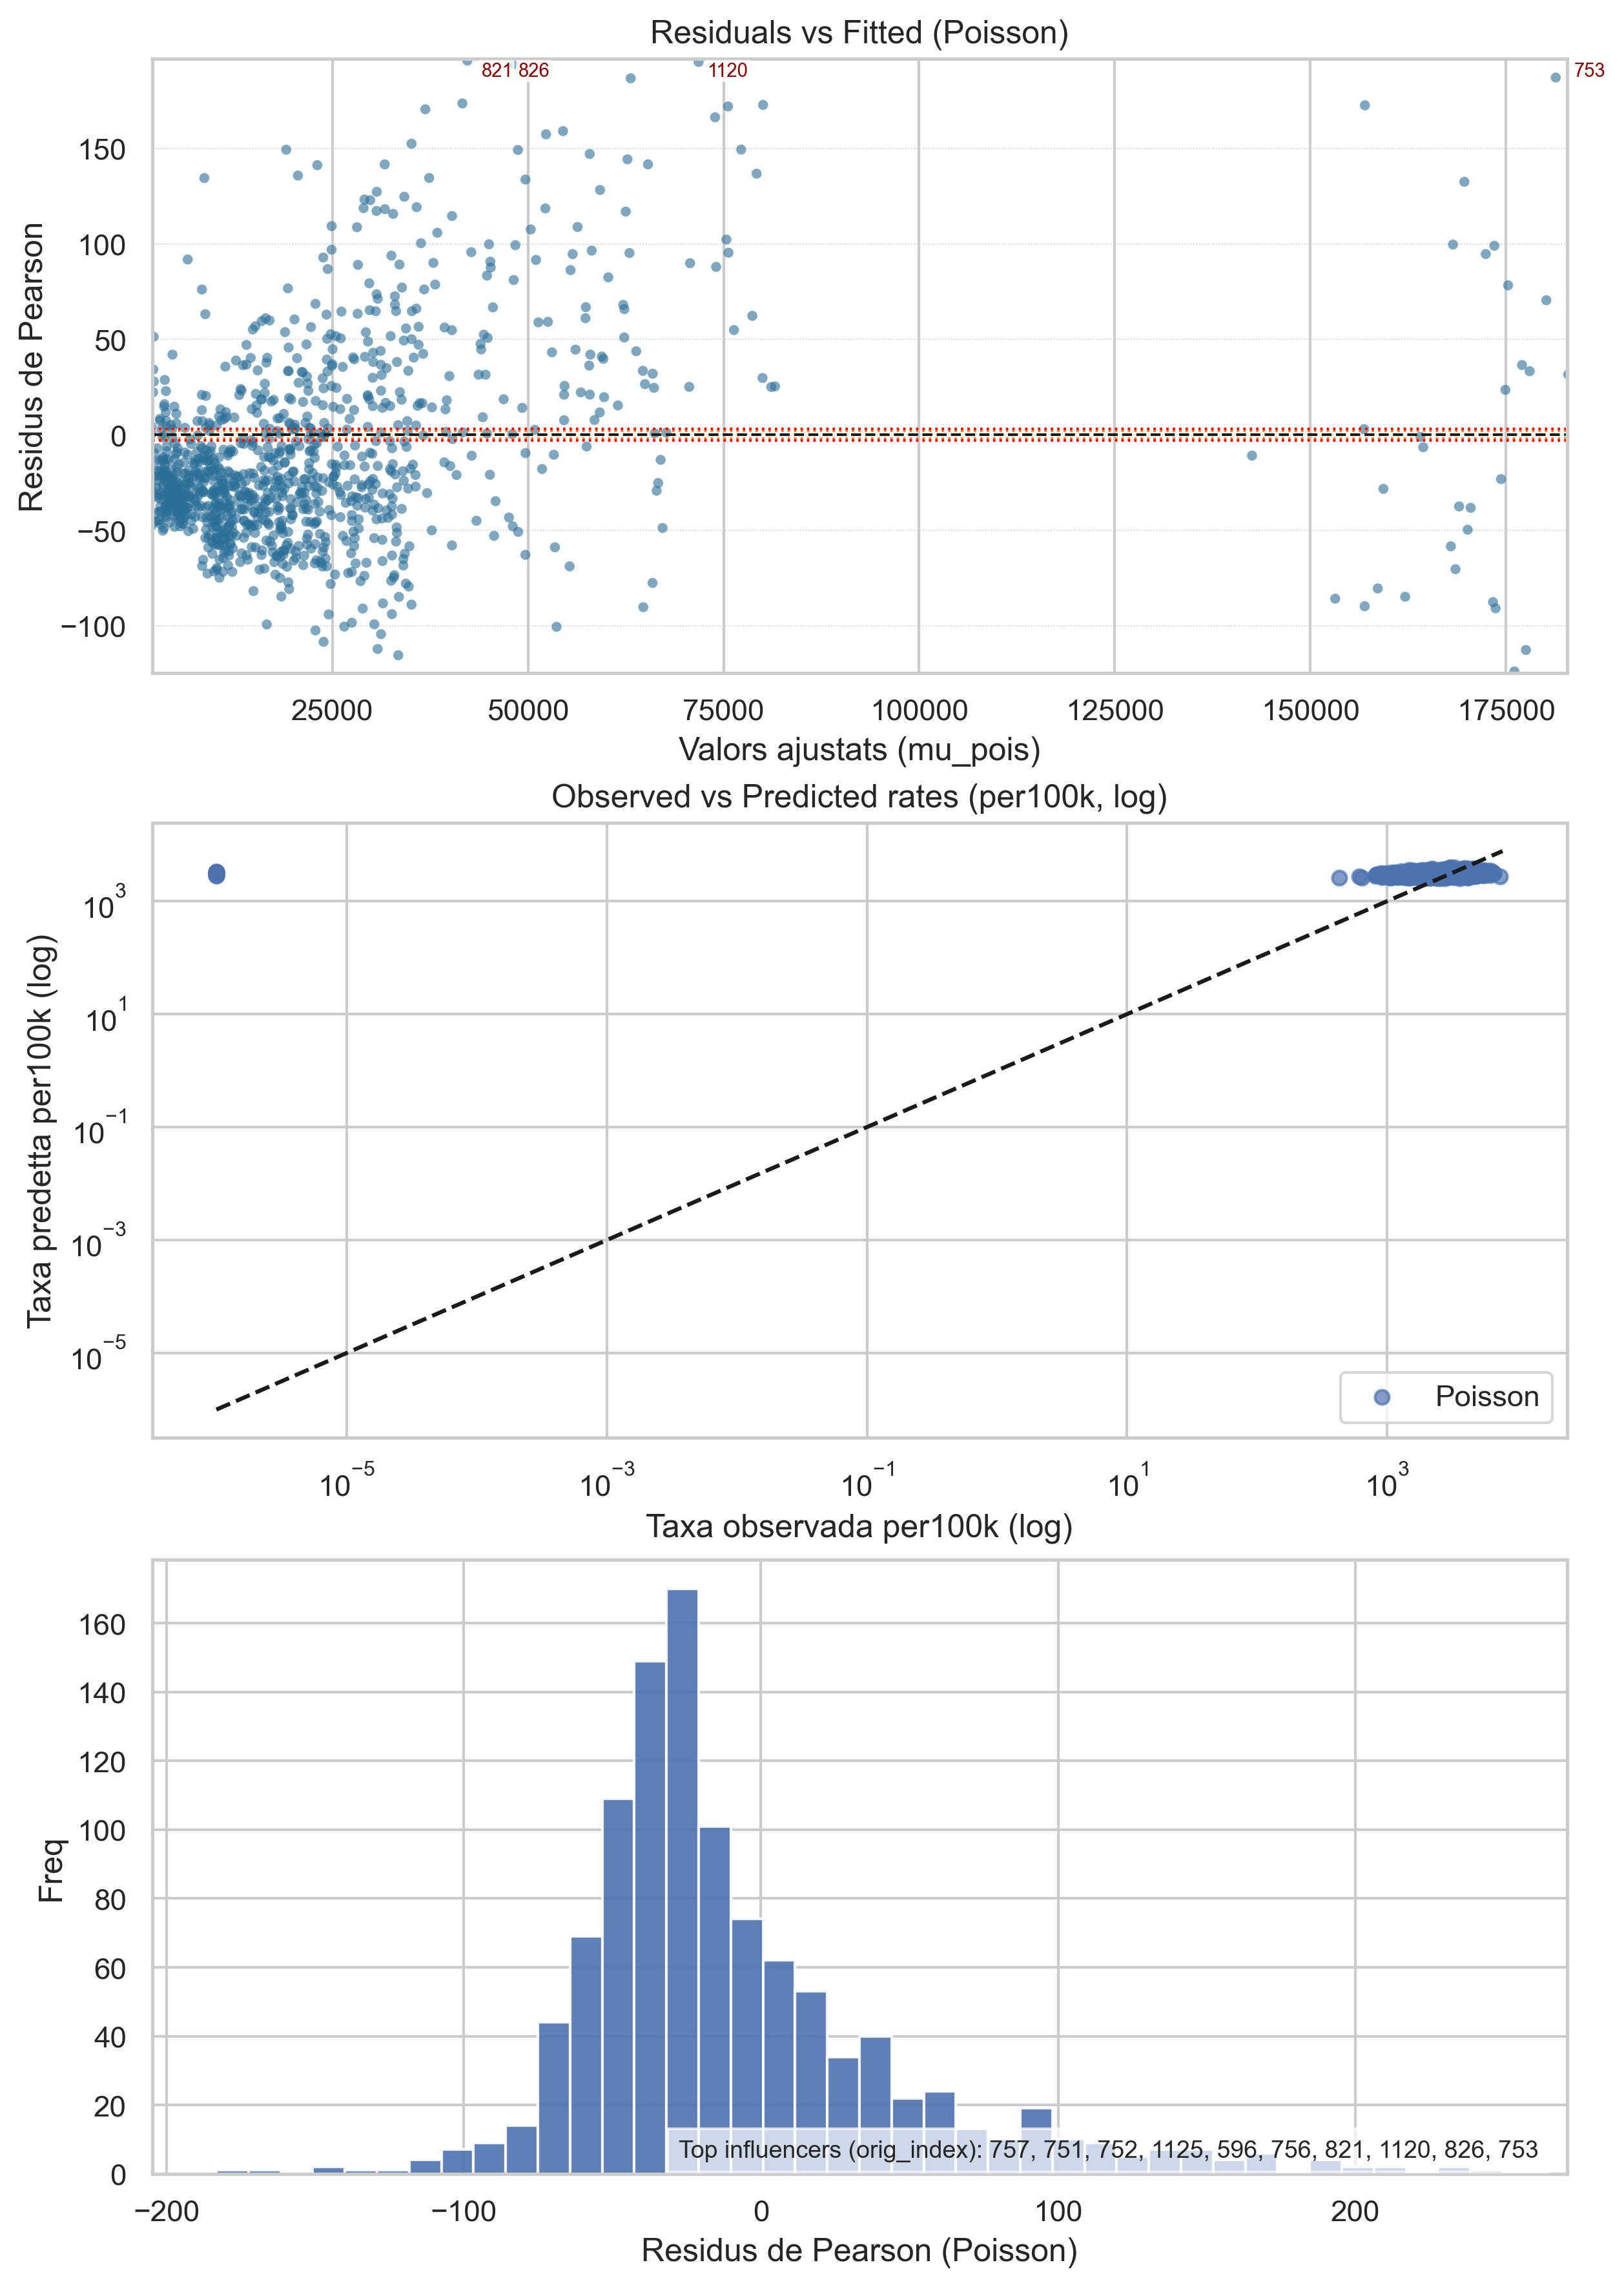

  denuncies: n=1092 disp=3085.336 AIC=3391711.84
Processant dependent: ordres


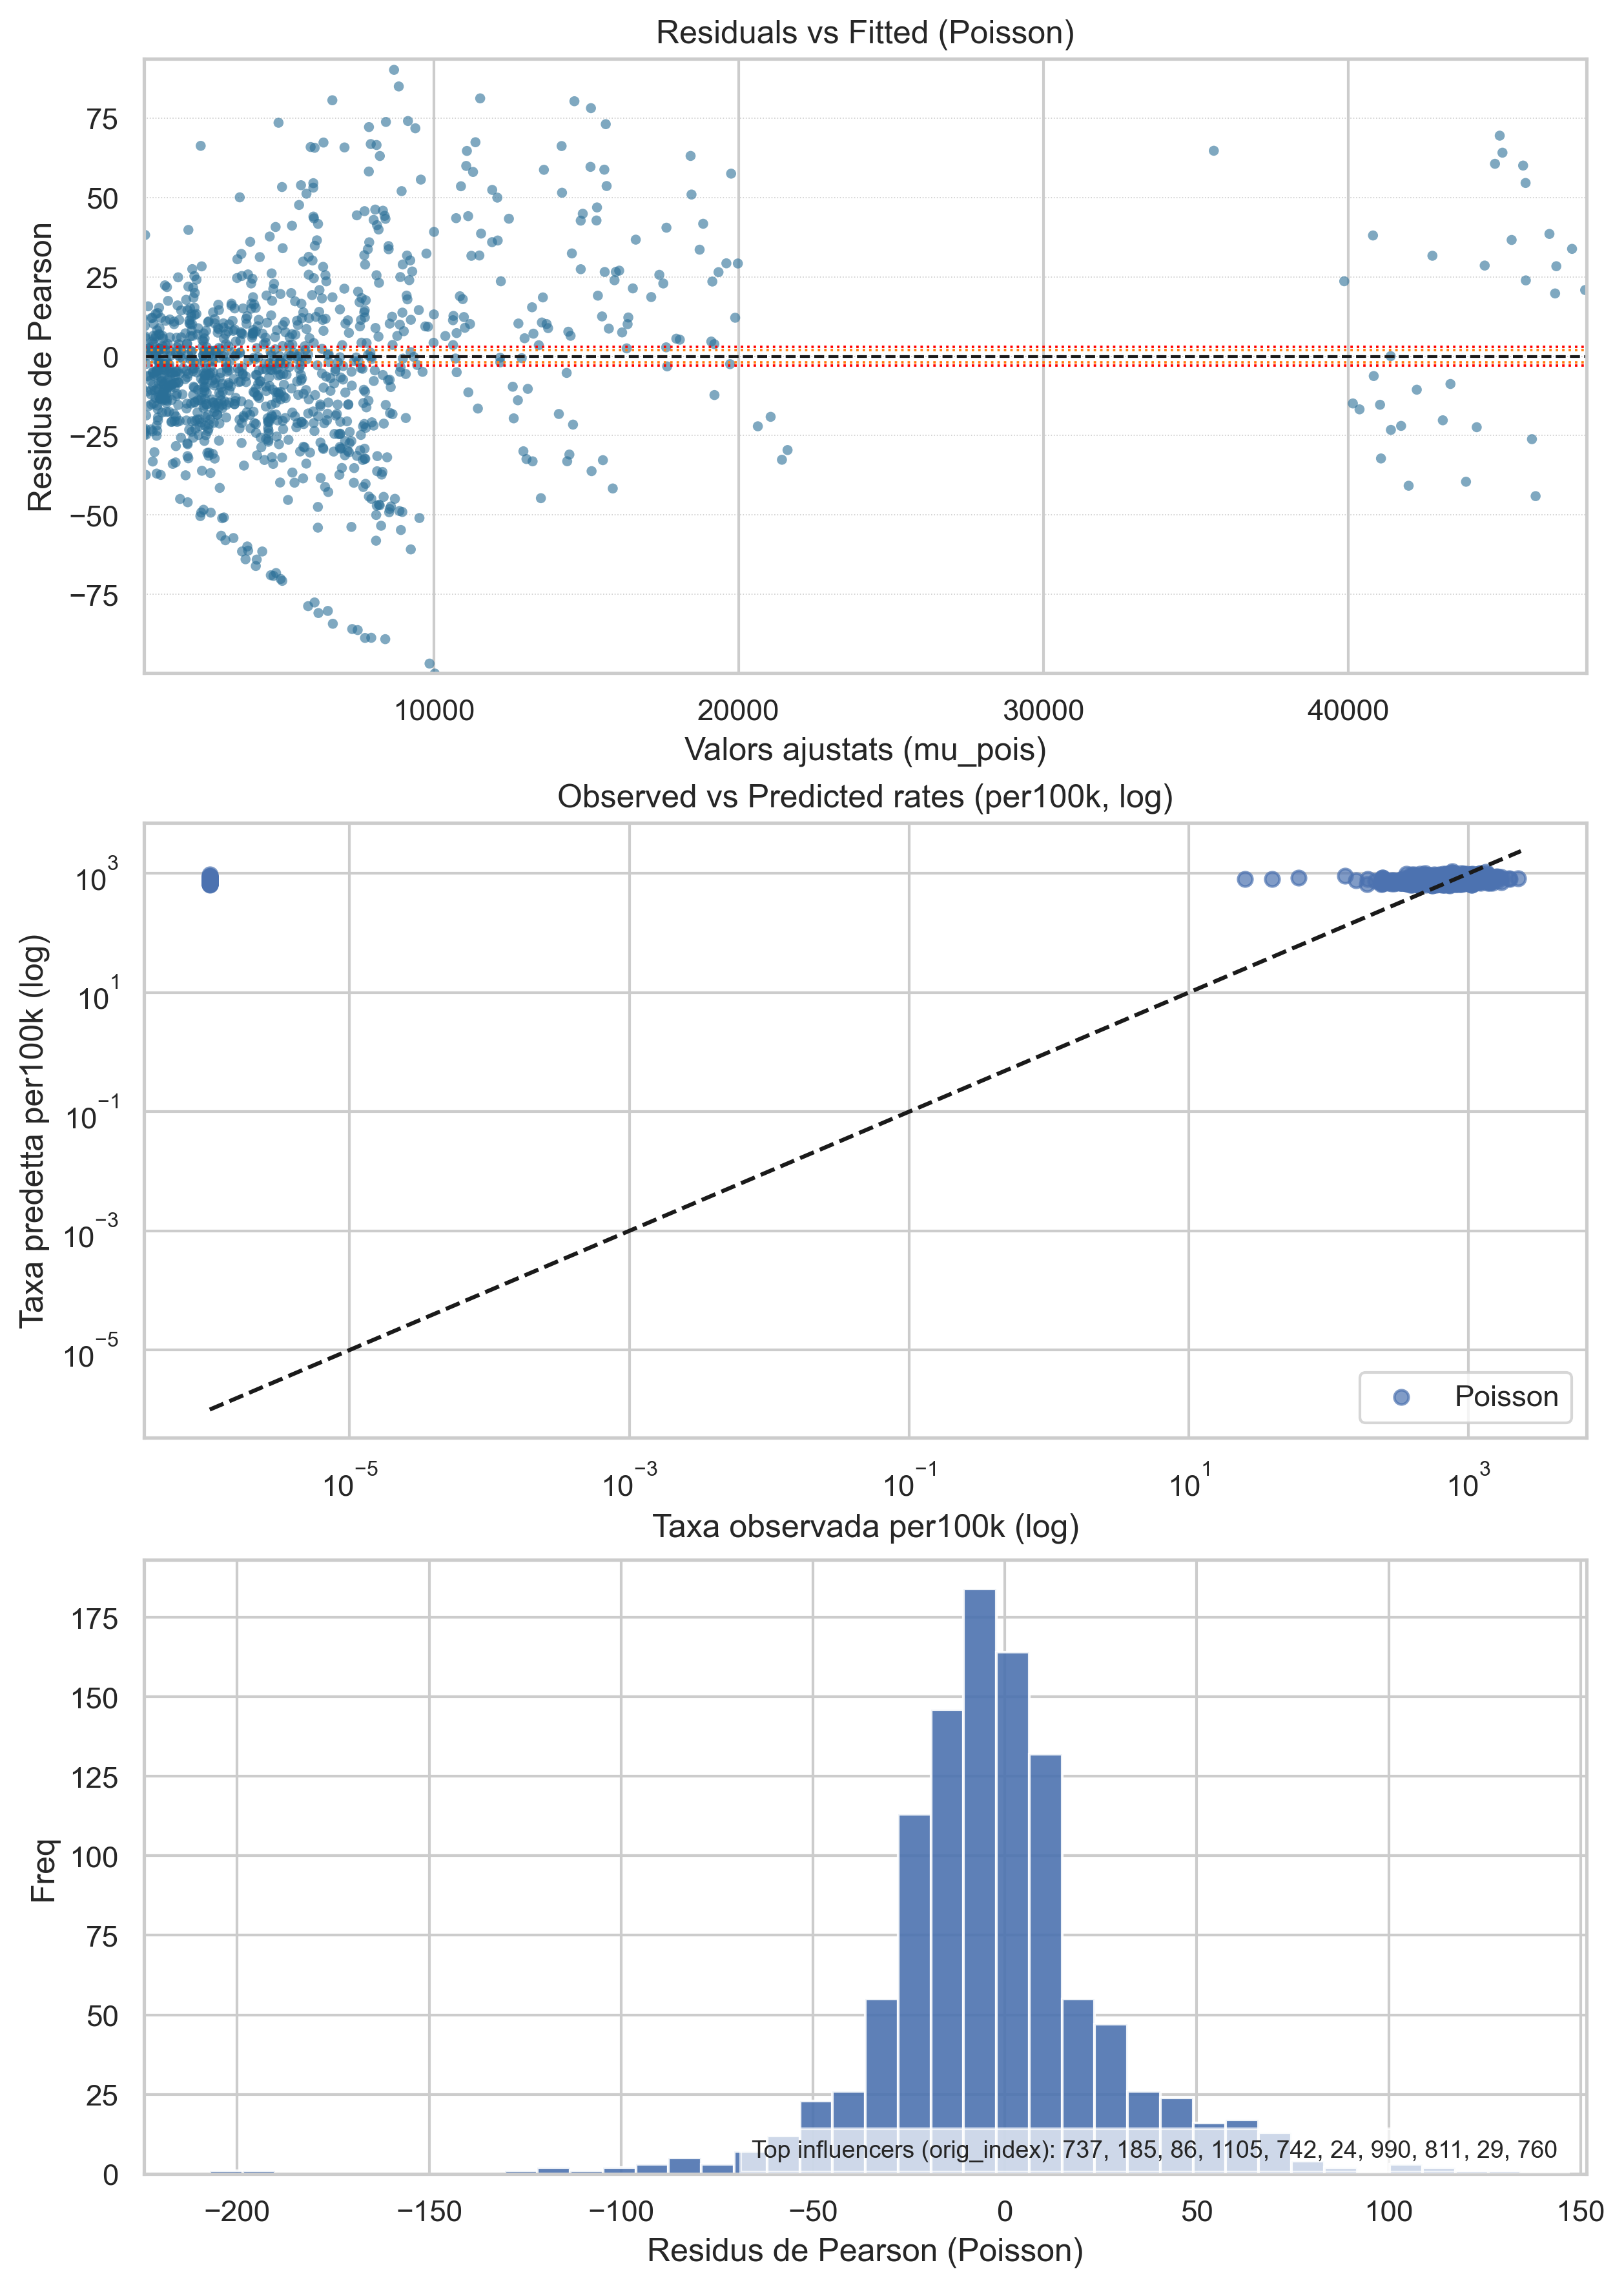

  ordres: n=1092 disp=929.716 AIC=1321349.16
Processament complet. Resultats a: diagnostics_poisson_hc3_output_fixed_labels


In [7]:
# Diagnostics Poisson + HC3 amb plotting de residus millorat (etiquetes petites i no solapades)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set(style="whitegrid")
plt.rcParams.update({"font.size": 11})

# ---------- CONFIGURACIÓ ----------
PATH = r"C:\Users\bfeli\rates_all_metrics_cleaned.csv" 
OUTDIR = "diagnostics_poisson_hc3_output_fixed_labels"
os.makedirs(OUTDIR, exist_ok=True)

DEPENDENTS_COUNTS = ["feminicidis", "denuncies", "ordres"]
PREDICTOR = "votes_per100k_used"
CONTROLS = ["atur_annual_mean_pct", "immigracio_per100k"]
OFFSET_COL = "population"
TOP_K = 10
PDF_SUMMARY = os.path.join(OUTDIR, "diagnostics_poisson_hc3_A4_vertical_fixed_labels.pdf")
DPI = 300


def safe_log(x):
    return np.log(np.maximum(x, 1e-9))

def fit_poisson_hc3(y, X, offset):
    glm = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
    res = glm.fit()
    try:
        res_rob = res.get_robustcov_results(cov_type='HC3')
    except Exception:
        res_rob = res
    return res, res_rob

def pearson_dispersion(y, mu, p):
    with np.errstate(divide='ignore', invalid='ignore'):
        pearson = (y - mu) / np.sqrt(np.maximum(mu, 1e-9))
    disp = np.nansum(pearson**2) / max(1, (len(y) - p))
    return disp, pearson

def irr_table(res_rob):
    params = res_rob.params
    cov = res_rob.cov_params()
    se = np.sqrt(np.diag(cov))
    z = 1.96
    irr = np.exp(params)
    irr_low = np.exp(params - z*se)
    irr_high = np.exp(params + z*se)
    df = pd.DataFrame({
        "term": params.index,
        "coef": params.values,
        "se": se,
        "irr": irr,
        "irr_lo": irr_low,
        "irr_hi": irr_high
    })
    return df

# --------- Dibuixar el panell de Residuals vs Fitted sobre un axis ----------
def draw_residuals_panel(ax, df_diag, fitted_col="mu_pois", y_col="y", index_col="orig_index",
                         top_k=5, y_lim=6, min_abs_pearson_to_label=2.5):

    eps = 1e-9
    df = df_diag.copy().reset_index(drop=True)

    # calcular pearson 
    if "pearson_pois" not in df.columns:
        mu = df[fitted_col].astype(float).values
        y = df[y_col].astype(float).values
        pearson = (y - mu) / np.sqrt(np.maximum(mu, eps))
        df["pearson_pois"] = pearson

    x = df[fitted_col].astype(float).values
    yres = df["pearson_pois"].astype(float).values

    # primer definim límits visuals raonables (percentils)
    try:
        xmin_pct, xmax_pct = np.nanpercentile(x, [1.0, 99.0])
    except Exception:
        xmin_pct, xmax_pct = np.nanmin(x), np.nanmax(x)
    try:
        ymin_pct, ymax_pct = np.nanpercentile(yres, [1.0, 99.0])
    except Exception:
        ymin_pct, ymax_pct = -y_lim, y_lim

    # ampliar una mica els límits per marge
    x_margin = max((xmax_pct - xmin_pct) * 0.04, 1e-6)
    y_margin = max((ymax_pct - ymin_pct) * 0.08, 0.5)

    x_left = max(xmin_pct - x_margin, np.nanmin(x))
    x_right = min(xmax_pct + x_margin, np.nanmax(x) if np.isfinite(np.nanmax(x)) else xmax_pct + x_margin)
    y_bottom = min(ymin_pct - y_margin, -y_lim)
    y_top = max(ymax_pct + y_margin, y_lim)

    # establir límits abans de plotar i anotacions (això evita que get_xlim doni valors inesperats)
    ax.set_xlim(left=x_left, right=x_right)
    ax.set_ylim(bottom=y_bottom, top=y_top)

    # jitter x per reduir sobreposició
    rng = np.random.default_rng(42)
    x_range = x_right - x_left if (x_right > x_left) else 1.0
    jitter_scale = x_range * 0.006
    x_jitter = x + rng.normal(scale=jitter_scale, size=len(x))

    # dibuixar punts
    ax.scatter(x_jitter, yres, s=14, alpha=0.6, color="#2A6F97", edgecolors='none')
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.axhline(2, color='tab:orange', linestyle=':', linewidth=0.9)
    ax.axhline(-2, color='tab:orange', linestyle=':', linewidth=0.9)
    ax.axhline(3, color='red', linestyle=':', linewidth=0.9)
    ax.axhline(-3, color='red', linestyle=':', linewidth=0.9)
    ax.grid(axis='y', linestyle=':', linewidth=0.4)

    # seleccionar candidats per etiquetar: top_k per abs pearson però també filtrant amb min_abs_pearson_to_label
    df["abs_pearson"] = np.abs(df["pearson_pois"])
    candidates = df[df["abs_pearson"] >= min_abs_pearson_to_label]
    if len(candidates) == 0:
        candidates = df.nlargest(top_k, "abs_pearson")
    else:
        candidates = candidates.nlargest(top_k, "abs_pearson")

    fontsize_label = 7
    placed_y = []

    for _, row in candidates.iterrows():
        xi = float(row[fitted_col])
        yi = float(row["pearson_pois"])
        label = str(int(row[index_col])) if index_col in row else ""

        # coordenades de text inicial (intents pos i pos)
        x_text = xi
        y_text = yi

        # comprobar si el punt està dins els límits; si surt, es marca i es col·loca etiqueta al marge amb fletxa
        out_right = xi > x_right
        out_left = xi < x_left
        out_top = yi > y_top
        out_bottom = yi < y_bottom

        # si està dins, intentem posar l'etiqueta prop del punt amb petit offset,
        # i si s'obre solapament, movem verticalment (bucle simple)
        if not (out_right or out_left or out_top or out_bottom):
            # offset lleuger a la dreta
            x_text = xi + 0.01 * x_range
            y_text = yi
            # evitar solapaments verticals
            tries = 0
            vgap = max(0.06, 0.04 * (y_top - y_bottom))
            while any(abs(y_text - py) < vgap for py in placed_y) and tries < 50:
                y_text += vgap * (1 if (tries % 2 == 0) else -1) * (tries//2 + 1)
                tries += 1
            # limitar dins y límits
            if y_text > (y_top - 0.02*(y_top - y_bottom)):
                y_text = y_top - 0.02*(y_top - y_bottom)
            if y_text < (y_bottom + 0.02*(y_top - y_bottom)):
                y_text = y_bottom + 0.02*(y_top - y_bottom)

            ha = 'left'
            va = 'center'
            ax.text(x_text, y_text, label, fontsize=fontsize_label, color='darkred',
                    ha=ha, va=va, bbox=dict(facecolor='white', alpha=0.7, pad=0.3))
            placed_y.append(y_text)

        else:
            # punt fora: col·loquem l'etiqueta a la vora corresponent i dibuixem una fletxa
            # si punt a la dreta o xi està molt prop del marge dret -> etiqueta dret, amb arrow cap al punt
            if out_right:
                x_text = x_right - 0.01 * x_range
                ha = 'right'
            elif out_left:
                x_text = x_left + 0.01 * x_range
                ha = 'left'
            else:
                # si està dins en x però fora en y, posarem a l'interior en x i al top/bottom per y
                x_text = np.clip(xi, x_left + 0.02*x_range, x_right - 0.02*x_range)
                ha = 'center'

            # y_text posat al marge vertical corresponent
            if out_top:
                y_text = y_top - 0.02*(y_top - y_bottom)
            elif out_bottom:
                y_text = y_bottom + 0.02*(y_top - y_bottom)

            va = 'center'
            # dibuixar text i arrow
            ax.annotate(label, xy=(xi, yi), xytext=(x_text, y_text),
                        fontsize=fontsize_label, color='darkred',
                        ha=ha, va=va,
                        bbox=dict(facecolor='white', alpha=0.8, pad=0.3),
                        arrowprops=dict(arrowstyle='->', color='gray', lw=0.6, alpha=0.8))
            placed_y.append(y_text)

    ax.set_xlabel(f"Valors ajustats ({fitted_col})")
    ax.set_ylabel("Residus de Pearson")
    ax.set_title(f"Residuals vs Fitted (Poisson)")
    return ax

# ---------- Principal ----------
df = pd.read_csv(PATH, encoding="utf-8-sig", low_memory=False)
print("Fitxer llegit:", PATH, "n =", len(df))

needed = [OFFSET_COL, PREDICTOR] + CONTROLS + DEPENDENTS_COUNTS
miss = [c for c in needed if c not in df.columns]
if miss:
    raise SystemExit(f"Falten columnes: {miss}")

results = []


for dep in DEPENDENTS_COUNTS:
    print("Processant dependent:", dep)
    cols = [dep, OFFSET_COL, PREDICTOR] + CONTROLS
    sub = df[cols].dropna().copy().reset_index().rename(columns={"index":"orig_index"})
    if len(sub) < 10:
        print("  Pocs casos:", len(sub), " - saltant.")
        continue

    y = sub[dep].astype(float)
    pop = sub[OFFSET_COL].astype(float)
    offset = safe_log(pop)

    # preparar X
    X = sub[[PREDICTOR] + CONTROLS].astype(float)
    X = sm.add_constant(X, has_constant='add')

    # preprocessar numèric senzill
    for col in [PREDICTOR, "immigracio_per100k"]:
        if col in X.columns and (X[col].max() / max(1.0, abs(X[col].median())) > 100):
            X[col] = np.log1p(X[col])

    cols_no_const = [c for c in X.columns if c != 'const']
    X.loc[:, cols_no_const] = (X[cols_no_const] - X[cols_no_const].mean()) / X[cols_no_const].std(ddof=0)

    # ajustar Poisson + HC3
    try:
        res_pois, res_pois_rob = fit_poisson_hc3(y, X, offset)
    except Exception as e:
        print("  Error ajustant Poisson:", e)
        continue

    mu_pois = res_pois.predict(X, offset=offset)
    p_pois = int(res_pois.df_model + 1)
    disp_pois, pearson_pois = pearson_dispersion(y.values, mu_pois, p_pois)

    irr_df = irr_table(res_pois_rob)
    irr_df.to_csv(os.path.join(OUTDIR, f"irr_poisson_{dep}.csv"), index=False)

    # diagnostics DataFrame
    diag = sub[['orig_index']].copy()
    diag['y'] = y.values
    diag['population'] = pop.values
    diag['mu_pois'] = mu_pois
    diag['rate_obs'] = (y.values / pop.values) * 100000
    diag['rate_pois'] = (mu_pois / pop.values) * 100000
    diag['pearson_pois'] = pearson_pois
    diag_path = os.path.join(OUTDIR, f"diag_{dep}.csv")
    diag.to_csv(diag_path, index=False)

    top_idx = diag.reindex(diag['pearson_pois'].abs().sort_values(ascending=False).index)['orig_index'].head(TOP_K).tolist()

    # Generar figura vertical A4: utilitzar draw_residuals_panel per al primer panell
    fig, axes = plt.subplots(3, 1, figsize=(8.27, 11.69), dpi=DPI, constrained_layout=True)

    # Primer panell: Residuals vs Fitted amb la nova funció (etiquetes petites/no solapants)
    draw_residuals_panel(axes[0], diag, fitted_col='mu_pois', y_col='y', index_col='orig_index', top_k=TOP_K, y_lim=6)

    # Segon panell: Observed vs Predicted rates (log)
    ax = axes[1]
    eps = 1e-6
    x = np.maximum(diag['rate_obs'].fillna(eps).values, eps)
    y_p = np.maximum(diag['rate_pois'].fillna(eps).values, eps)
    ax.scatter(x, y_p, s=28, alpha=0.7, color="#4C72B0", label="Poisson")
    mx = max(np.nanmax(x), np.nanmax(y_p)) * 1.05
    if np.isfinite(mx) and mx > 0:
        ax.plot([eps, mx], [eps, mx], linestyle='--', color='k')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel("Taxa observada per100k (log)")
    ax.set_ylabel("Taxa predetta per100k (log)")
    ax.set_title("Observed vs Predicted rates (per100k, log)")
    ax.legend()

    # Tercer panell: histograma residus de Pearson amb top influencers
    ax = axes[2]
    ax.hist(diag['pearson_pois'].dropna(), bins=40, color="#4C72B0", alpha=0.9)
    ax.set_xlabel("Residus de Pearson (Poisson)")
    ax.set_ylabel("Freq")
    txt = "Top influencers (orig_index): " + ", ".join(map(str, top_idx[:TOP_K]))
    ax.text(0.98, 0.02, txt, transform=ax.transAxes, ha='right', va='bottom', fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

    # desar PNG
    png_path = os.path.join(OUTDIR, f"diagnostics_{dep}.png")
    fig.savefig(png_path, dpi=DPI, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    # Sensibilitat: excloure top-K i refit Poisson+HC3
    mask_keep = ~diag['orig_index'].isin(top_idx)
    y2 = y.values[mask_keep]
    X2 = X.loc[mask_keep.values, :].copy()
    offset2 = offset[mask_keep.values]
    if len(y2) >= max(10, X2.shape[1] + 1):
        try:
            res2, res2_rob = fit_poisson_hc3(y2, X2, offset2)
            mu2 = res2.predict(X2, offset=offset2)
            disp2, _ = pearson_dispersion(y2, mu2, int(res2.df_model + 1))
            irr2 = irr_table(res2_rob)
            irr2.to_csv(os.path.join(OUTDIR, f"irr_poisson_{dep}_no_top{TOP_K}.csv"), index=False)
        except Exception as e:
            print("  L'anàlisi de sensibilitat ha fallat per", dep, e)
            disp2 = np.nan
    else:
        disp2 = np.nan

    results.append({
        "dependent": dep,
        "n": len(y),
        "aic_poisson": float(res_pois.aic),
        "llf_poisson": float(res_pois.llf),
        "dispersion_poisson": float(disp_pois),
        "dispersion_poisson_no_topK": float(disp2)
    })

    print(f"  {dep}: n={len(y)} disp={disp_pois:.3f} AIC={res_pois.aic:.2f}")

pd.DataFrame(results).to_csv(os.path.join(OUTDIR, "models_summary_poisson_hc3_fixed_labels.csv"), index=False)
print("Processament complet. Resultats a:", OUTDIR)

In [8]:
# assumir res_pois (Poisson fit) existeix i X, y, offset definits
start = res_pois.params
glm_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial(), offset=offset)
nb_res = glm_nb.fit(start_params=start, maxiter=500, method='newton')
print(nb_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 ordres   No. Observations:                 1092
Model:                            GLM   Df Residuals:                     1088
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -10127.
Date:                Sun, 04 Jan 2026   Deviance:                       1107.9
Time:                        22:19:25   Pearson chi2:                     204.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02414
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.9550 

In [9]:
# Ajustar Negative Binomial per a "denuncies" i "ordres"

import os
import sys
import traceback
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# CONFIGURACIÓ ------------------------------------------------
PATH = r"C:\Users\bfeli\rates_all_metrics_cleaned.csv" 
OUTDIR = "nb_attempt_results"
os.makedirs(OUTDIR, exist_ok=True)

DEPENDENTS = ["denuncies", "ordres"]
PREDICTORS = ["votes_per100k_used", "atur_annual_mean_pct", "immigracio_per100k"]
OFFSET_COL = "population"
MIN_POP = 1.0  # per evitar log(0)
# -------------------------------------------------------

def safe_log(x):
    return np.log(np.maximum(x, 1e-9))

def method_of_moments_alpha(y, mu):
    num = np.nansum((y - mu)**2 - mu)
    den = np.nansum(mu**2)
    if den <= 0:
        return np.nan
    alpha = num / den
    return max(alpha, 0.0)

def try_nb_for_dependent(df, dep):
    out = {"dependent": dep, "status": "not_started", "messages": []}
    try:
        sub = df[[dep, OFFSET_COL] + PREDICTORS].dropna().copy().reset_index().rename(columns={"index":"orig_index"})
        n = len(sub)
        if n < 20:
            out["status"] = "too_few"
            out["messages"].append(f"Too few rows ({n})")
            return out

        y = sub[dep].astype(float).values
        pop = sub[OFFSET_COL].astype(float).clip(lower=MIN_POP).values
        offset = safe_log(pop)

        # Preparar X: log1p per a predictors asimètrics (heurístic) i estandarditzar
        Xraw = sub[PREDICTORS].astype(float).copy()
        for c in ["votes_per100k_used", "immigracio_per100k"]:
            if c in Xraw.columns:
                med = np.nanmedian(np.abs(Xraw[c]))
                mx = np.nanmax(np.abs(Xraw[c]))
                if med == 0:
                    ratio = np.inf
                else:
                    ratio = mx / med
                if ratio > 100:  # fortament esbiaixat
                    Xraw[c] = np.log1p(Xraw[c])
        scaler = StandardScaler()
        Xs = scaler.fit_transform(Xraw)
        X = sm.add_constant(pd.DataFrame(Xs, columns=["z_"+c for c in Xraw.columns]))

        # 1) Fit Poisson (IRLS) i desar
        glm_pois = sm.GLM(y, X, family=sm.families.Poisson(), offset=offset)
        try:
            res_pois = glm_pois.fit()
        except Exception as e:
            # intentar una millor intercepció inicial
            mean_rate = y.sum() / pop.sum()
            start_intercept = np.log(max(mean_rate, 1e-9))
            start = np.zeros(X.shape[1])
            start[0] = start_intercept
            res_pois = glm_pois.fit(start_params=start, maxiter=200, method='newton')

        mu_pois = res_pois.predict(X, offset=offset)
        p = int(res_pois.df_model) + 1
        pearson = (y - mu_pois) / np.sqrt(np.maximum(mu_pois, 1e-9))
        dispersion = np.nansum(pearson**2) / max(1, (len(y) - p))

        out.update({
            "n": int(n),
            "dispersion_pois": float(dispersion),
            "poisson_summary": str(res_pois.summary())
        })

        # estimar alpha pel mètode pel mètode de diagnòstic
        alpha_mom = method_of_moments_alpha(y, mu_pois)
        out["alpha_moments"] = float(alpha_mom)

        # 2) Provar GLM NegativeBinomial amb diversos optimitzadors
        nb_attempts = []
        try_orders = [
            {"method":"newton","maxiter":500},
            {"method":"bfgs","maxiter":1000},
            {"method":"nm","maxiter":2000},
        ]
        # paràmetres d'incici: Poisson paràrmetres
        start0 = res_pois.params.values if hasattr(res_pois, "params") else None

        nb_result = None
        last_exc = None
        for opt in try_orders:
            try:
                glm_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial(), offset=offset)
                if start0 is not None:
                    nb_res = glm_nb.fit(start_params=start0, maxiter=opt["maxiter"], method=opt["method"], disp=False)
                else:
                    nb_res = glm_nb.fit(maxiter=opt["maxiter"], method=opt["method"], disp=False)
                nb_result = nb_res
                nb_attempts.append({"method":opt["method"], "status":"success"})
                break
            except Exception as e:
                last_exc = e
                nb_attempts.append({"method":opt["method"], "status":"fail", "error": repr(e)})
                

        out["nb_attempts"] = nb_attempts

        if nb_result is not None:
            out["status"] = "nb_converged"
            out["nb_summary"] = str(nb_result.summary())
            # extreure alfa si està disponible (el NB de la família GLM no exposa alfa directament)
            try:
                # statsmodels emmagatzema les estimacions d'escala/alfa a nb_result.scale o result.mle_settings
                alpha_est = getattr(nb_result, "scale", None)
                out["nb_alpha_estimate"] = float(alpha_est) if alpha_est is not None else None
            except Exception:
                out["nb_alpha_estimate"] = None

            # Desar el resum de resultats NB
            with open(os.path.join(OUTDIR, f"nb_summary_{dep}.txt"), "w", encoding="utf-8") as f:
                f.write(out["nb_summary"])
        else:
            out["status"] = "nb_failed"
            out["messages"].append("Negative Binomial GLM no ha convergit amb els optimitzadors provats.")
            out["last_exception"] = repr(last_exc)
            # Desar els mètodes provats 
            with open(os.path.join(OUTDIR, f"nb_attempts_{dep}.txt"), "w", encoding="utf-8") as f:
                f.write("NB attempts:\n")
                for a in nb_attempts:
                    f.write(str(a) + "\n")
                f.write("\nLast exception:\n")
                f.write(traceback.format_exc())

        # Desar poisson i diagnostics CSV
        diag = sub[["orig_index"]].copy()
        diag["y"] = y
        diag["population"] = pop
        diag["mu_pois"] = mu_pois
        diag["rate_obs"] = (y / pop) * 100000
        diag["rate_pois"] = (mu_pois / pop) * 100000
        diag["pearson_pois"] = pearson
        diag.to_csv(os.path.join(OUTDIR, f"diag_{dep}.csv"), index=False)

        # Desar resum poisson 
        with open(os.path.join(OUTDIR, f"poisson_summary_{dep}.txt"), "w", encoding="utf-8") as f:
            f.write(str(res_pois.summary()))

        # Desar diccionari final
        pd.Series(out).to_json(os.path.join(OUTDIR, f"nb_result_meta_{dep}.json"))
        return out

    except Exception as e:
        tb = traceback.format_exc()
        return {"dependent": dep, "status": "error", "error": repr(e), "traceback": tb}

def main():
    print("Reading:", PATH)
    df = pd.read_csv(PATH, encoding="utf-8-sig", low_memory=False)
    results = []
    for dep in DEPENDENTS:
        print("Processament", dep)
        res = try_nb_for_dependent(df, dep)
        results.append(res)
        print("  Done:", dep, res.get("status"))
        # escriure un resum en format CSV
        outpath = os.path.join(OUTDIR, f"nb_summary_meta_{dep}.json")
        pd.Series(res).to_json(outpath)
    # aggregate
    pd.DataFrame(results).to_csv(os.path.join(OUTDIR, "nb_attempts_overview.csv"), index=False)
    print("Resultats en:", OUTDIR)

In [10]:
# nb_res és l'objecte retornat per glm_nb.fit(...)
import numpy as np
import pandas as pd

params = nb_res.params
conf = nb_res.conf_int()
se = np.sqrt(np.diag(nb_res.cov_params()))
irr = np.exp(params)
irr_low = np.exp(conf[0])
irr_high = np.exp(conf[1])

df_irr = pd.DataFrame({
    "term": params.index,
    "coef": params.values,
    "se": se,
    "irr": irr,
    "irr_lo": irr_low,
    "irr_hi": irr_high
})
df_irr.to_csv("irr_negativebinomial_denuncies.csv", index=False)
print(df_irr)

                                      term      coef        se       irr  \
const                                const -4.955017  0.030267  0.007048   
votes_per100k_used      votes_per100k_used  0.097111  0.032081  1.101983   
atur_annual_mean_pct  atur_annual_mean_pct  0.180887  0.037306  1.198280   
immigracio_per100k      immigracio_per100k  0.113424  0.035013  1.120107   

                        irr_lo    irr_hi  
const                 0.006642  0.007479  
votes_per100k_used    1.034827  1.173497  
atur_annual_mean_pct  1.113790  1.289178  
immigracio_per100k    1.045818  1.199673  


In [11]:
# y, mu sòn numpy arrays a partir de les dades y nb_res o poisson mu
def alpha_moments(y, mu):
    num = np.nansum((y - mu)**2 - mu)
    den = np.nansum(mu**2)
    if den <= 0:
        return np.nan
    return max(num/den, 0.0)

# mu_pois
alpha_hat = alpha_moments(y, mu_pois)
print("alpha (moments) =", alpha_hat)

alpha (moments) = 0.10363068218878793


In [12]:
# top‑influencers 
import pandas as pd
diag = pd.read_csv("diagnostics_poisson_hc3_output_fixed_labels/diag_feminicidis.csv")
top10 = diag.reindex(diag['pearson_pois'].abs().sort_values(ascending=False).index).head(10)
top10[['orig_index','y','population','mu_pois','rate_obs','rate_pois','pearson_pois']].to_csv("top_influencers_feminicidis.csv", index=False)
print(top10[['orig_index','y','mu_pois','pearson_pois']])

     orig_index    y   mu_pois  pearson_pois
725         794  2.0  0.116691      5.513186
467         512  3.0  0.259132      5.384275
71           78  6.0  1.034697      4.881342
70           77  5.0  0.956415      4.134695
538         589  6.0  1.298971      4.124707
868         951  6.0  1.333370      4.041365
824         903  5.0  0.999867      4.000398
397         434  2.0  0.229644      3.694308
444         487  5.0  1.133413      3.631899
519         568  2.0  0.239711      3.595342
